- Train Against: Heuristic agent <br>
- Evaluate Against: Random move agent <br>
- Network A & B

In [2]:
from ConnectFourBoard import ConnectFourBoard
from QLearningAgent import DQNAgent
import numpy as np
import random
import torch
import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class HeuristicOpponent:
    def __init__(self, env):
        self.env = env

    def choose_action(self):
        # Try to win in one move
        for action in self.env.get_available_actions():
            temp_env = copy.deepcopy(self.env)
            temp_env.step(action)
            if temp_env.winner == -1:
                return action

        # Try to block opponent's win in one move
        for action in self.env.get_available_actions():
            temp_env = copy.deepcopy(self.env)
            temp_env.current_player = 1  # Agent's turn in simulated env
            temp_env.step(action)
            if temp_env.winner == 1:
                return action

        # Fallback to center preference (often stronger)
        if 3 in self.env.get_available_actions():
            return 3

        # Otherwise pick random
        return random.choice(self.env.get_available_actions())

In [4]:
def train_agent(agent, episodes=5000, eval_every=1000, eval_games=100, opponent=None):
    rewards = []
    win_percentages = []

    for ep in range(1, episodes + 1):
        state, _ = agent.env.reset()
        done = False
        total_reward = 0

        while not done:
            if agent.env.current_player == 1:
                # Agent's turn
                action = agent.select_action(state)
                next_state, reward, done, _, _ = agent.env.step(action)
                agent.store_transition(state, action, reward, next_state, done)
                agent.update()
                state = next_state
            else:
                # Opponent is heuristic
                action = opponent.choose_action()
                state, reward, done, _, _ = agent.env.step(action)

        total_reward = agent.env.winner
        rewards.append(total_reward)

        agent.epsilon = max(agent.epsilon_end,
                            agent.epsilon * agent.epsilon_decay)

        if ep % agent.target_update_freq == 0:
            agent.target_net.load_state_dict(agent.q_net.state_dict())

       # Evaluate against random baseline
        if ep % eval_every == 0:
            # Temporarily turn off exploration
            epsilon_temp = agent.epsilon
            agent.epsilon = 0.0

            win_count = 0
            for _ in range(eval_games):
                state, _ = agent.env.reset()
                done = False
                while not done:
                    if agent.env.current_player == 1:
                        action = agent.select_action(state)
                    else:
                        action = random.choice(agent.env.get_available_actions())
                    state, reward, done, _, _ = agent.env.step(action)

                if agent.env.winner == 1:
                    win_count += 1

            # Restore exploration
            agent.epsilon = epsilon_temp

            win_percentage = (win_count / eval_games) * 100
            win_percentages.append(win_percentage)
            print(f"Episode {ep}: Agent won {win_percentage:.2f}% against random baseline")
                
    plt.plot(range(eval_every, episodes + 1, eval_every), win_percentages)
    plt.xlabel("Training Episodes")
    plt.ylabel("Win % vs Random Baseline")
    plt.title("DQN Agent Evaluation Performance")
    plt.grid(True)
    plt.show()

    return rewards, win_percentages

Episode 1000: Agent won 68.00% against random baseline
Episode 2000: Agent won 48.00% against random baseline
Episode 3000: Agent won 81.00% against random baseline
Episode 4000: Agent won 82.00% against random baseline
Episode 5000: Agent won 73.00% against random baseline
Episode 6000: Agent won 75.00% against random baseline
Episode 7000: Agent won 80.00% against random baseline
Episode 8000: Agent won 84.00% against random baseline
Episode 9000: Agent won 77.00% against random baseline
Episode 10000: Agent won 78.00% against random baseline
Episode 11000: Agent won 77.00% against random baseline
Episode 12000: Agent won 80.00% against random baseline
Episode 13000: Agent won 88.00% against random baseline
Episode 14000: Agent won 76.00% against random baseline
Episode 15000: Agent won 80.00% against random baseline
Episode 16000: Agent won 74.00% against random baseline
Episode 17000: Agent won 72.00% against random baseline
Episode 18000: Agent won 73.00% against random baseline
E

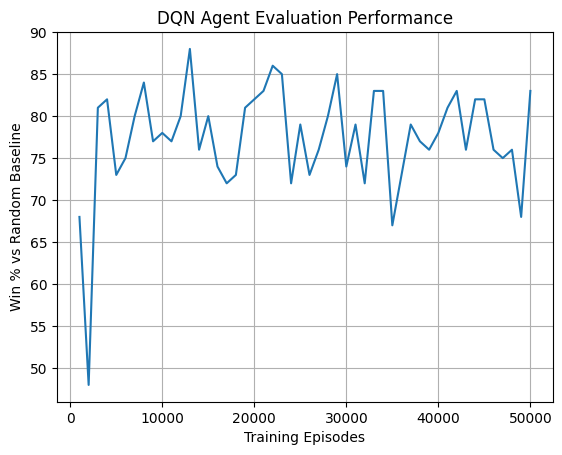

In [7]:
eval_every = 1000
episodes = 50000
env = ConnectFourBoard()
opponent = HeuristicOpponent(env)
agent = DQNAgent(env, device="cuda" if torch.cuda.is_available() else "cpu", network="A")
rewards, win_percentages = train_agent(
    agent, episodes=episodes, eval_every=eval_every, eval_games=100, opponent=opponent
)

In [8]:
# Save the results rewards and win percentages in a file
np.savez(
    "training_results_selfplay_heuristic_A.npz",
    rewards=rewards,
    win_percentages=win_percentages,
)

In [ ]:
eval_every = 1000
episodes = 50000
env = ConnectFourBoard()
opponent = HeuristicOpponent(env)
agent = DQNAgent(env, device="cuda" if torch.cuda.is_available() else "cpu", network="B")
rewards, win_percentages = train_agent(
    agent, episodes=episodes, eval_every=eval_every, eval_games=100, opponent=opponent
)

Episode 1000: Agent won 91.00% against random baseline
Episode 2000: Agent won 92.00% against random baseline
Episode 3000: Agent won 92.00% against random baseline
Episode 4000: Agent won 83.00% against random baseline
Episode 5000: Agent won 87.00% against random baseline
Episode 6000: Agent won 91.00% against random baseline
Episode 7000: Agent won 90.00% against random baseline
Episode 8000: Agent won 94.00% against random baseline
Episode 9000: Agent won 89.00% against random baseline
Episode 10000: Agent won 87.00% against random baseline
Episode 11000: Agent won 88.00% against random baseline
Episode 12000: Agent won 87.00% against random baseline
Episode 13000: Agent won 88.00% against random baseline
Episode 14000: Agent won 91.00% against random baseline
Episode 15000: Agent won 85.00% against random baseline
Episode 16000: Agent won 89.00% against random baseline


In [ ]:
np.savez(
    "training_results_selfplay_heuristic_B.npz",
    rewards=rewards,
    win_percentages=win_percentages,
)